In [1]:
# imports

import matplotlib as mpl
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr

from barnacle.tensors import SparseCPTensor
from matplotlib import pyplot as plt
from pathlib import Path
from tlviz.factor_tools import factor_match_score
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import precision_score
from sklearn.metrics.pairwise import cosine_similarity


In [2]:
# functions to build continuous colormap
# source: https://towardsdatascience.com/beautiful-custom-colormaps-with-matplotlib-5bab3d1f0e72

def hex_to_rgb(value):
    '''
    Converts hex to rgb colours
    value: string of 6 characters representing a hex colour.
    Returns: list length 3 of RGB values'''
    value = value.strip("#") # removes hash symbol if present
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))


def rgb_to_dec(value):
    '''
    Converts rgb to decimal colours (i.e. divides each value by 256)
    value: list (length 3) of RGB values
    Returns: list (length 3) of decimal values'''
    return [v/256 for v in value]

def get_continuous_cmap(hex_list, float_list=None):
    ''' creates and returns a color map that can be used in heat map figures.
        If float_list is not provided, colour map graduates linearly between each color in hex_list.
        If float_list is provided, each color in hex_list is mapped to the respective location in float_list. 
        
        Parameters
        ----------
        hex_list: list of hex code strings
        float_list: list of floats between 0 and 1, same length as hex_list. Must start with 0 and end with 1.
        
        Returns
        ----------
        colour map'''
    rgb_list = [rgb_to_dec(hex_to_rgb(i)) for i in hex_list]
    if float_list:
        pass
    else:
        float_list = list(np.linspace(0,1,len(rgb_list)))
        
    cdict = dict()
    for num, col in enumerate(['red', 'green', 'blue']):
        col_list = [[float_list[i], rgb_list[i][num], rgb_list[i][num]] for i in range(len(float_list))]
        cdict[col] = col_list
    cmp = mcolors.LinearSegmentedColormap('my_cmp', segmentdata=cdict, N=256)
    return cmp


In [36]:
# set aesthetic parameters

line_color = '#0F0A0A'    # dark
# line_color = '#E5E4E2'    # light

neutral_color = '#E0E0E0'

# thursday
accent_colors = ['#9B5DE5', '#FFAC69', '#00C9AE', '#FD3F92', '#0F0A0A', 
                 '#959AB1', '#FFDB66', '#63B9FF','#FFB1CA', '#4F1DD7']

grays = ['#0F0A0A', '#52525E', '#747688', '#959AB1', '#959AB1', '#CECFD5', '#E0E0E0']

style = {'axes.edgecolor': line_color,
         'axes.labelcolor': line_color,
         'text.color': line_color,
         'xtick.color': line_color,
         'ytick.color': line_color,
         'font.family': 'Helvetica',
         'font.Helvetica': ['Helvetica']}

palette = sns.color_palette(accent_colors)

sns.set_context('talk', rc={'lines.linewidth': 2})
sns.set_palette(palette)
# sns.set_palette('tab20')
sns.set_style('ticks', style)

plt.rcParams['legend.frameon'] = False
plt.rcParams['axes.spines.left'] = True
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.bottom'] = True
plt.rcParams['axes.facecolor'] = 'none'
plt.rcParams['figure.facecolor'] = 'none'
plt.rcParams['patch.linewidth'] = 0
plt.rcParams['patch.edgecolor'] = 'none'
plt.rcParams['savefig.dpi'] = 300

div_hexes = ['#7222D3', neutral_color, '#FF780A']
div_cmap = get_continuous_cmap(div_hexes)


# import data

In [12]:
# read in aligned model datasets

datapath = Path('../../data')

pro_ds = xr.open_dataset(datapath / '5-models/pro-aligned-models.nc')
syn_ds = xr.open_dataset(datapath / '5-models/syn-aligned-models.nc')

pro_ds

<xarray.Dataset>
Dimensions:           (bootstrap: 100, replicate: 3, component: 20,
                       ortholog: 5084, clade: 3, samplename: 76)
Coordinates:
  * bootstrap         (bootstrap) int64 0 1 2 3 4 5 6 7 ... 93 94 95 96 97 98 99
  * replicate         (replicate) object 'A' 'B' 'C'
  * component         (component) int64 1 2 3 4 5 6 7 8 ... 14 15 16 17 18 19 20
  * ortholog          (ortholog) int64 60000001 60000002 ... 60040287 60040292
  * clade             (clade) object 'HLI' 'HLII' 'LLI'
  * samplename        (samplename) object 'G1.SURF.NS.S02C1.15m' ... 'G3.UW.N...
Data variables:
    componentweights  (bootstrap, replicate, component) float64 ...
    geneweights       (bootstrap, replicate, component, ortholog) float64 ...
    taxonweights      (bootstrap, replicate, component, clade) float64 ...
    sampleweights     (bootstrap, replicate, component, samplename) float64 ...
    sample            (bootstrap, replicate, samplename) object ...

In [13]:
# read in metadata

sample_df = pd.read_csv(datapath / 'metadata/archive/sample_metadata_merged.csv')

sample_df

,samplename,cruise,year,datetime,latitude,longitude,depth,dataset,samplegroup,timefraction,timeclass,experiment,condition,treatment,timepoint
0,G2.DCM.NS.S11C2.50m,Gradients 2,2017,6/6/17 6:56,36.999833,-158.000,50,Gradients 2 DCM,depth profiles,0.29,6am,NaN,NaN,NaN,NaN
1,G2.DCM.NS.S15C2.56m,Gradients 2,2017,6/9/17 5:30,34.000167,-158.000,56,Gradients 2 DCM,depth profiles,0.23,6am,NaN,NaN,NaN,NaN
2,G2.DCM.NS.S17C3.87m,Gradients 2,2017,6/10/17 9:34,32.000167,-158.000,87,Gradients 2 DCM,depth profiles,0.40,10am,NaN,NaN,NaN,NaN
3,G2.DCM.NS.S18C2.95m,Gradients 2,2017,6/11/17 5:50,29.582000,-158.002,95,Gradients 2 DCM,depth profiles,0.24,6am,NaN,NaN,NaN,NaN
4,G3.DEPTH.NS.S4C6.75m,Gradients 3,2019,4/16/19 8:00,41.670000,-158.050,75,Gradients 3 depth profile,depth profiles,0.33,10am,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82,G3.DEPTH.NS.S6C7.15m,Gradients 3,2019,4/22/19 6:44,32.920000,-158.000,15,Gradients 3 depth profile,surface transect,0.28,6am,NaN,NaN,NaN,NaN
83,G3.UW.NS.UW40_1.7m,Gradients 3,2019,4/24/19 5:57,40.880000,-158.000,7,Gradients 3 underway,surface transect,0.25,6am,NaN,NaN,NaN,NaN
84,G3.DEPTH.NS.S8C2.15m,Gradients 3,2019,4/24/19 14:47,42.330000,-158.000,15,Gradients 3 depth profile,surface transect,0.62,2pm,NaN,NaN,NaN,NaN
85,G3.UW.NS.UW40_2.7m,Gradients 3,2019,4/25/19 6:01,40.090000,-158.000,7,Gradients 3 underway,surface transect,0.25,6am,NaN,NaN,NaN,NaN


# arrange data

In [17]:
# select only "robust" clusters

pro_clusters = [
    'pro2', 'pro3', 'pro4', 'pro5', 'pro6', 'pro8', 'pro9', 'pro10', 'pro11', 'pro12', 
    'pro13', 'pro14', 'pro15', 'pro17'
]
syn_clusters = [
    'syn3', 'syn4', 'syn5', 'syn6', 'syn7', 'syn8', 'syn9', 'syn10', 'syn12', 'syn14', 'syn15'
]
robust_clusters = pro_clusters + syn_clusters
genus_map = dict(zip(robust_clusters, ['Prochlorococcus' if c in pro_clusters else 'Synechococcus' for c in robust_clusters]))


In [7]:
# Prochlorococcus weights

# pull out pro gene weight data
pro_gene_df = pro_ds.median(dim=['bootstrap', 'replicate']).geneweights.T.to_pandas()
pro_gene_df = pro_gene_df.rename(columns=dict(zip(pro_gene_df.columns, [f"pro{i}" for i in pro_gene_df.columns])))
# select only robust components
pro_gene_df = pro_gene_df.loc[:, pro_clusters]

# pull out pro sample weight data
pro_sample_df = pro_ds.median(dim=['bootstrap', 'replicate']).sampleweights.T.to_pandas()
pro_sample_df = pro_sample_df.rename(columns=dict(zip(pro_sample_df.columns, 
                                                      [f"pro{i}" for i in pro_sample_df.columns])))
# select only robust components
pro_sample_df = pro_sample_df.loc[:, pro_clusters]

# pull out pro taxon weight data
pro_taxon_df = pro_ds.median(dim=['bootstrap', 'replicate']).taxonweights.T.to_pandas()
pro_taxon_df = pro_taxon_df.rename(columns=dict(zip(pro_taxon_df.columns, 
                                                    [f"pro{i}" for i in pro_taxon_df.columns])))
# select only robust components
pro_taxon_df = pro_taxon_df.loc[:, pro_clusters]

pro_taxon_df


component,pro2,pro3,pro4,pro5,pro6,pro8,pro9,pro10,pro11,pro12,pro13,pro14,pro15,pro17
clade,,,,,,,,,,,,,,
HLI,0.000000,0.231321,0.031735,0.980233,1.000000,0.968806,0.963480,0.999056,0.000000,0.980705,0.008565,0.765282,0.228778,0.993705
HLII,0.999815,0.971750,0.999494,0.191434,0.000000,0.225528,0.103088,0.000000,0.999846,0.138196,0.055127,0.263614,0.969434,0.033151
LLI,0.019028,0.044757,0.000000,0.029264,0.000112,0.092666,0.245905,0.042395,0.017054,0.112266,0.998305,0.556192,0.091547,0.106407


In [8]:
# Synechococcus weights

# pull out syn gene weight data
syn_gene_df = syn_ds.median(dim=['bootstrap', 'replicate']).geneweights.T.to_pandas()
syn_gene_df = syn_gene_df.rename(columns=dict(zip(syn_gene_df.columns, [f"syn{i}" for i in syn_gene_df.columns])))
# select only robust components
syn_gene_df = syn_gene_df.loc[:, syn_clusters]

# pull out syn sample weight data
syn_sample_df = syn_ds.median(dim=['bootstrap', 'replicate']).sampleweights.T.to_pandas()
syn_sample_df = syn_sample_df.rename(columns=dict(zip(syn_sample_df.columns, 
                                                      [f"syn{i}" for i in syn_sample_df.columns])))
# select only robust components
syn_sample_df = syn_sample_df.loc[:, syn_clusters]

# pull out syn taxon weight data
syn_taxon_df = syn_ds.median(dim=['bootstrap', 'replicate']).taxonweights.T.to_pandas()
syn_taxon_df = syn_taxon_df.rename(columns=dict(zip(syn_taxon_df.columns, 
                                                    [f"syn{i}" for i in syn_taxon_df.columns])))
# select only robust components
syn_taxon_df = syn_taxon_df.loc[:, syn_clusters]

syn_taxon_df


component,syn3,syn4,syn5,syn6,syn7,syn8,syn9,syn10,syn12,syn14,syn15
clade,,,,,,,,,,,
5.1A-I,0.557495,0.0,0.491009,0.084280,0.042960,0.023633,0.256513,0.032912,0.369346,0.984906,0.497976
5.1A-II,0.000000,0.0,0.005612,0.016145,0.062117,0.028488,0.345598,0.839706,0.109028,0.022326,0.002765
5.1A-III,0.000047,0.0,0.001039,0.018538,0.029819,0.998887,0.192478,0.523887,0.040658,0.010798,0.000000
5.1A-IV,0.828734,1.0,0.809219,0.107028,0.031191,0.010678,0.494330,0.088103,0.574152,0.141605,0.851934
5.1B-VII,0.037729,0.0,0.241601,0.696894,0.045071,0.017281,0.575084,0.032328,0.620374,0.076658,0.058141
CDR2,0.020850,0.0,0.201717,0.685712,0.994174,0.010428,0.423049,0.069677,0.341933,0.048475,0.057992


# Comparison between _Prochlorococcus_ & _Synechococcus_ weights

In [20]:
# combine pro & syn data

# make joint gene weights df
geneweights_df = pd.merge(
    pro_gene_df, syn_gene_df, left_index=True, right_index=True, how='outer').fillna(0)
# make gene correlation matrix
corr_gene_df = pd.DataFrame(
    geneweights_df.corr(), 
    index=geneweights_df.columns, 
    columns=geneweights_df.columns
)

# make joint sample weights df
sampleweights_df = pd.merge(
    pro_sample_df, syn_sample_df, left_index=True, right_index=True, how='outer').fillna(0)
# melt dataframe
sampleweights_df = sampleweights_df.melt(value_name='weight', ignore_index=False).reset_index()
sampleweights_df['genus'] = sampleweights_df['component'].map(genus_map)
# join sample data
sampleweights_df = pd.merge(sampleweights_df, sample_df, on='samplename', how='left')

# make joint taxon weights df
taxonweights_df = pd.merge(
    pro_taxon_df, syn_taxon_df, left_index=True, right_index=True, how='outer').fillna(0)
# melt dataframe
taxonweights_df = taxonweights_df.melt(value_name='weight', ignore_index=False).reset_index()
taxonweights_df['genus'] = taxonweights_df['component'].map(genus_map)

sampleweights_df


,samplename,component,weight,genus,cruise,year,datetime,latitude,longitude,depth,dataset,samplegroup,timefraction,timeclass,experiment,condition,treatment,timepoint
0,G1.SURF.NS.S02C1.15m,pro2,0.000000,Prochlorococcus,Gradients 1,2016,4/20/16 5:51,23.495833,-157.994333,15,Gradients 1 surface,surface transect,0.24,6am,NaN,NaN,NaN,NaN
1,G1.SURF.NS.S04C1.15m,pro2,0.007625,Prochlorococcus,Gradients 1,2016,4/22/16 5:40,28.143167,-158.000667,15,Gradients 1 surface,surface transect,0.24,6am,NaN,NaN,NaN,NaN
2,G1.SURF.NS.S06C1.15m,pro2,0.065150,Prochlorococcus,Gradients 1,2016,4/24/16 5:37,32.583500,-158.001667,15,Gradients 1 surface,surface transect,0.23,6am,NaN,NaN,NaN,NaN
3,G1.SURF.NS.S08C1.15m,pro2,0.001814,Prochlorococcus,Gradients 1,2016,4/26/16 5:43,37.301167,-158.001667,15,Gradients 1 surface,surface transect,0.24,6am,NaN,NaN,NaN,NaN
4,G1.SURF.NS.S09C1.15m,pro2,0.002316,Prochlorococcus,Gradients 1,2016,4/27/16 5:41,36.570000,-158.003167,15,Gradients 1 surface,surface transect,0.24,6am,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2170,G3.UW.NS.UW35_2.7m,syn15,0.004241,Synechococcus,Gradients 3,2019,4/26/19 5:55,35.830000,-158.000000,7,Gradients 3 underway,surface transect,0.25,6am,NaN,NaN,NaN,NaN
2171,G3.UW.NS.UW37_1.7m,syn15,0.041616,Synechococcus,Gradients 3,2019,4/20/19 6:12,37.000000,-158.000000,7,Gradients 3 underway,surface transect,0.26,6am,NaN,NaN,NaN,NaN
2172,G3.UW.NS.UW38_1.7m,syn15,0.002232,Synechococcus,Gradients 3,2019,4/15/19 5:37,38.970000,-158.000000,7,Gradients 3 underway,surface transect,0.23,6am,NaN,NaN,NaN,NaN
2173,G3.UW.NS.UW40_1.7m,syn15,0.000000,Synechococcus,Gradients 3,2019,4/24/19 5:57,40.880000,-158.000000,7,Gradients 3 underway,surface transect,0.25,6am,NaN,NaN,NaN,NaN


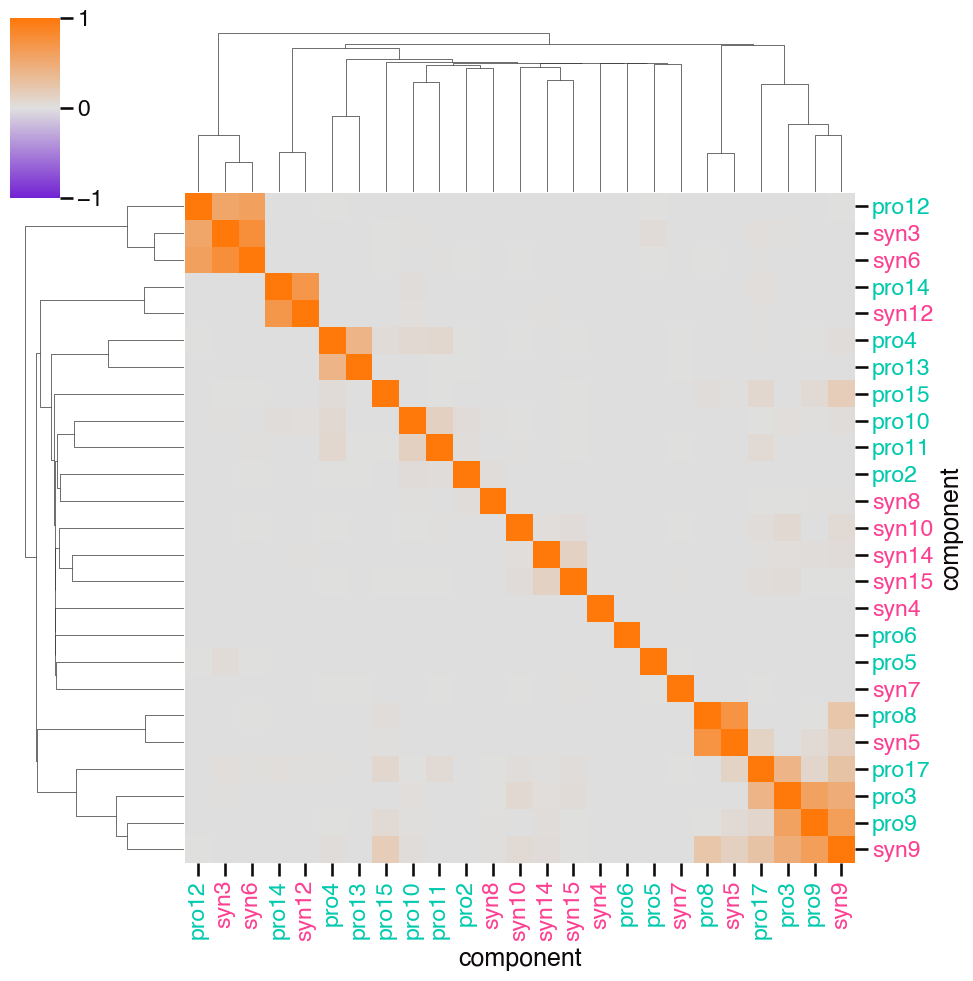

In [21]:
# cluster components by gene weight profile

# make cluster heatmap
g = sns.clustermap(
    corr_gene_df, 
    cmap=div_cmap, vmin=-1, vmax=1, cbar_kws={'shrink': .5}, 
    xticklabels=True, 
    yticklabels=True
)
# color ticks by pro/syn
for tick_axis in [g.ax_heatmap.axes.get_xticklabels(), g.ax_heatmap.axes.get_yticklabels()]: 
    for tick in tick_axis:
        if tick._text in pro_clusters:
            tick.set_color(sns.color_palette()[2])
        elif tick._text in syn_clusters:
            tick.set_color(sns.color_palette()[3])
            

In [27]:
taxonweights_df

,clade,component,weight,genus
0,5.1A-I,pro2,0.000000,Prochlorococcus
1,5.1A-II,pro2,0.000000,Prochlorococcus
2,5.1A-III,pro2,0.000000,Prochlorococcus
3,5.1A-IV,pro2,0.000000,Prochlorococcus
4,5.1B-VII,pro2,0.000000,Prochlorococcus
...,...,...,...,...
220,5.1B-VII,syn15,0.058141,Synechococcus
221,CDR2,syn15,0.057992,Synechococcus
222,HLI,syn15,0.000000,Synechococcus
223,HLII,syn15,0.000000,Synechococcus


# make joint summary figure

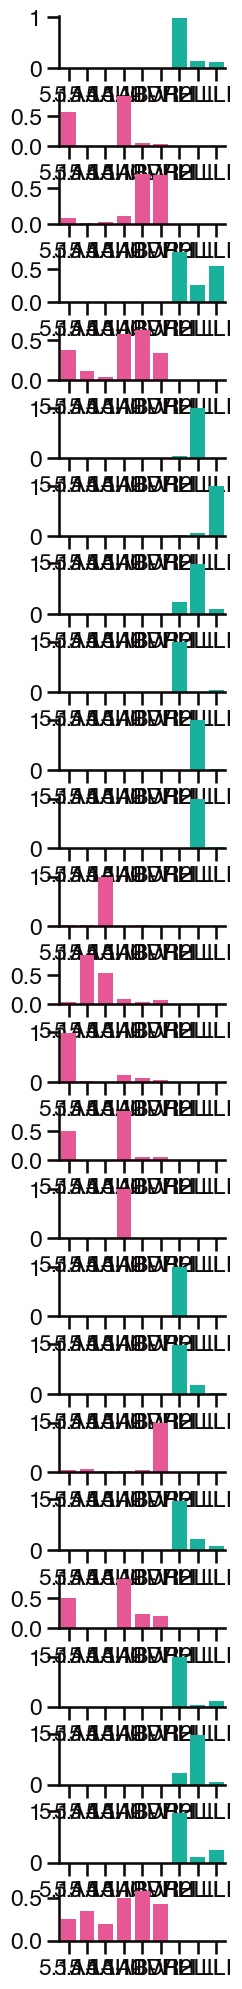

In [37]:
# make composite figure

fig = plt.figure(figsize=(15, 25))
grid = plt.GridSpec(25, 5, wspace=.5, hspace=.5)
annot_kwgs = {
    'xycoords': 'axes fraction', 'va': 'center', 'ha': 'left', 'fontsize': 22, 'annotation_clip': False
}


# plot panel a (cladogram)
# ax_a = plt.subplot(grid[:,0])
# ax_a.annotate('A', xy=(-0.2, 1.15), **annot_kwgs)

# plot sample weights
for i, cid in enumerate([robust_clusters[i] for i in g.dendrogram_row.reordered_ind]):
    axis = plt.subplot(grid[i, 1])
    plot_df = taxonweights_df[taxonweights_df['component'] == cid]
    sns.barplot(data=plot_df, x='clade', y='weight', hue='genus', hue_order=['Prochlorococcus', 'Synechococcus'], 
                palette=[sns.color_palette()[i] for i in [2, 3]], legend=False, ax=axis)
    axis.set(xlabel=None, ylabel=None)



In [22]:
sns.color_palette()

[(0.6078431372549019, 0.36470588235294116, 0.8980392156862745),
 (1.0, 0.6745098039215687, 0.4117647058823529),
 (0.0, 0.788235294117647, 0.6823529411764706),
 (0.9921568627450981, 0.24705882352941178, 0.5725490196078431),
 (0.058823529411764705, 0.0392156862745098, 0.0392156862745098),
 (0.5843137254901961, 0.6039215686274509, 0.6941176470588235),
 (1.0, 0.8588235294117647, 0.4),
 (0.38823529411764707, 0.7254901960784313, 1.0),
 (1.0, 0.6941176470588235, 0.792156862745098),
 (0.30980392156862746, 0.11372549019607843, 0.8431372549019608)]

In [30]:
plot_df

,clade,component,weight,genus
180,5.1A-I,syn9,0.256513,Synechococcus
181,5.1A-II,syn9,0.345598,Synechococcus
182,5.1A-III,syn9,0.192478,Synechococcus
183,5.1A-IV,syn9,0.494330,Synechococcus
184,5.1B-VII,syn9,0.575084,Synechococcus
185,CDR2,syn9,0.423049,Synechococcus
186,HLI,syn9,0.000000,Synechococcus
187,HLII,syn9,0.000000,Synechococcus
188,LLI,syn9,0.000000,Synechococcus
